In [1]:
amino_acid_codes = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V"
}

In [2]:
from Bio import SeqIO

protein_id_pdb = '4qyz'

# uni-prot accession number: Q46901
print('=== Alphafold Prediction ===')
alphafold_prediction_fn = 'AF-Q46901-F1-alphafold.pdb'
for af_record in SeqIO.parse(alphafold_prediction_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (af_record.id, af_record.annotations["chain"]))
    print(f'Sequence Length: {len(af_record.seq)}')

# pdb accession number: 4qyz
print('\n=== X-ray cryst. structure ===')
xray_crystal_structure_fn = '4qyz-pdb.pdb'
for pdb_record in SeqIO.parse(xray_crystal_structure_fn, "pdb-seqres"):
    print("Record id %s, chain %s" % (pdb_record.id, pdb_record.annotations["chain"]))
    print(f'Sequence Length: {len(pdb_record.seq)}')
    break # only one chain

=== Alphafold Prediction ===
Record id XXXX:A, chain A
Sequence Length: 502

=== X-ray cryst. structure ===
Record id 4QYZ:A, chain A
Sequence Length: 502


In [3]:
import pandas as pd
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np

def get_phi_psi(protein_id, pdb_file, window_size, chain_id):
    phi_psi = pd.DataFrame(columns=['res','phi', 'psi', 'seq', 'idx_in_seq', 'chain', 'pos_in_chain', 'protein_id'])
    parser = PDBParser()
    protein = parser.get_structure(protein_id, pdb_file)
    chain = protein[0][chain_id]
    chain.atom_to_internal_coordinates(verbose=True)
    resultDict = structure_rebuild_test(chain)
    if not resultDict['pass']:
        print(f"Failed {protein_id} {chain.id}")
        raise Exception('Failed to rebuild')
    residues = list(chain.get_residues())
    j = 0
    seq = ''
    for i in range(len(residues)):
        # Convert 3 char codes to 1 char codes
        if j == 0 and i+window_size < len(residues):
            seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i:i+window_size]])
        key = amino_acid_codes.get(residues[i].resname, 'X')
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
        psi = psi if psi else np.nan
        phi = phi if phi else np.nan
        phi_psi.loc[len(phi_psi)] = [key, phi, psi, seq, j, chain.id, residues[i].get_full_id()[3][1], protein.id]
        j = (j+1) % window_size
    residues = list(chain.get_residues())
    return phi_psi

In [4]:
WINDOW_SIZE = 15
chain_id = 'A'
phi_psi_pdb = get_phi_psi(protein_id_pdb, xray_crystal_structure_fn, WINDOW_SIZE, chain_id) 
phi_psi_af = get_phi_psi(protein_id_pdb, alphafold_prediction_fn, WINDOW_SIZE, chain_id)

/Users/musaazeem/dev/protein-dihedral-visualization/env/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 54744.
  warnings.warn(


chain break at GLU  137  due to MaxPeptideBond (1.4 angstroms) exceeded
chain break at ASN  323  due to MaxPeptideBond (1.4 angstroms) exceeded
chain break at LEU  358  due to MaxPeptideBond (1.4 angstroms) exceeded


In [59]:
from dotenv import load_dotenv
import os
import requests
import time
import pandas as pd
from tqdm import tqdm
load_dotenv()
PDBMINE_URL = os.getenv("PDBMINE_URL")

residue_chain = str(pdb_record.seq)
code_length = 1
broken_chains = []
# break into sections of length 100
for i in range(0, len(residue_chain), 50-WINDOW_SIZE):
    broken_chains.append(residue_chain[i:i+100])


In [66]:
import json
from pathlib import Path
json.dump(matches, Path('matches-4QYZ.json').open('w'), indent=2)

In [ ]:
matches = {}
for chain in tqdm(broken_chains[:-1]): # last one less than WINDOW_SIZE res
    response = requests.post(
        PDBMINE_URL + '/v1/api/query',
        json={
            "residueChain": chain,
            "codeLength": code_length,
            "windowSize": WINDOW_SIZE
        }
    )
    assert(response.ok)
    print(response.json())
    query_id = response.json().get('queryID')
    assert(query_id)

    time.sleep(20)
    while(True):
        response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
        if response.ok:
            matchesi = response.json()['frames']
            break
        else:
            print('Waiting')
            time.sleep(15)
    matches.update(matchesi)

In [69]:
from tqdm import tqdm

phi_psi_mined = pd.DataFrame(columns=['res','phi', 'psi', 'seq', 'idx_in_seq', 'chain', 'protein_id'])
for seq_win,v in tqdm(matches.items()):
    seq = seq_win[4:]
    for protein,seq_matches in v.items():
        # get phi and psi of each residue in window for each match
        protein_id, chain = protein.split('_')
        for seq_match in seq_matches:
            for i,match in enumerate(seq_match):
                res, phi, psi = match['residueName'], match['phi'], match['psi']
                phi_psi_mined.loc[len(phi_psi_mined)] = [res, phi, psi, seq, i, chain, protein_id]

100%|██████████| 1133/1133 [05:08<00:00,  3.67it/s]


In [71]:
phi_psi_mined.to_csv('phi_psi_mined_win15_4QYZ.csv', index=False)

In [108]:
phi_psi_mined_filtered = phi_psi_mined.copy()
phi_psi_mined_filtered = phi_psi_mined_filtered[phi_psi_mined_filtered.protein_id != '4QYZ']
phi_psi_mined_filtered['source'] = 'Query (PDBMine)'
phi_psi_pdb['source'] = 'X-ray (PDB)'
phi_psi_af['source'] = 'AlphaFold'

In [107]:
print(phi_psi_mined_filtered.protein_id.unique(), phi_psi_mined_filtered.shape)
print(phi_psi_pdb.protein_id.unique(), phi_psi_pdb.shape)
print(phi_psi_af.protein_id.unique(), phi_psi_af.shape)
phi_psi_mined_filtered.groupby('res').count()['phi'].describe()

['4U7U' '5CD4' '5H9E' '5H9F'] (89580, 8)
['4qyz'] (469, 9)
['4qyz'] (502, 8)


count      20.000000
mean     4479.000000
std      2059.395542
min      1282.000000
25%      2958.750000
50%      4775.000000
75%      5177.750000
max      9306.000000
Name: phi, dtype: float64

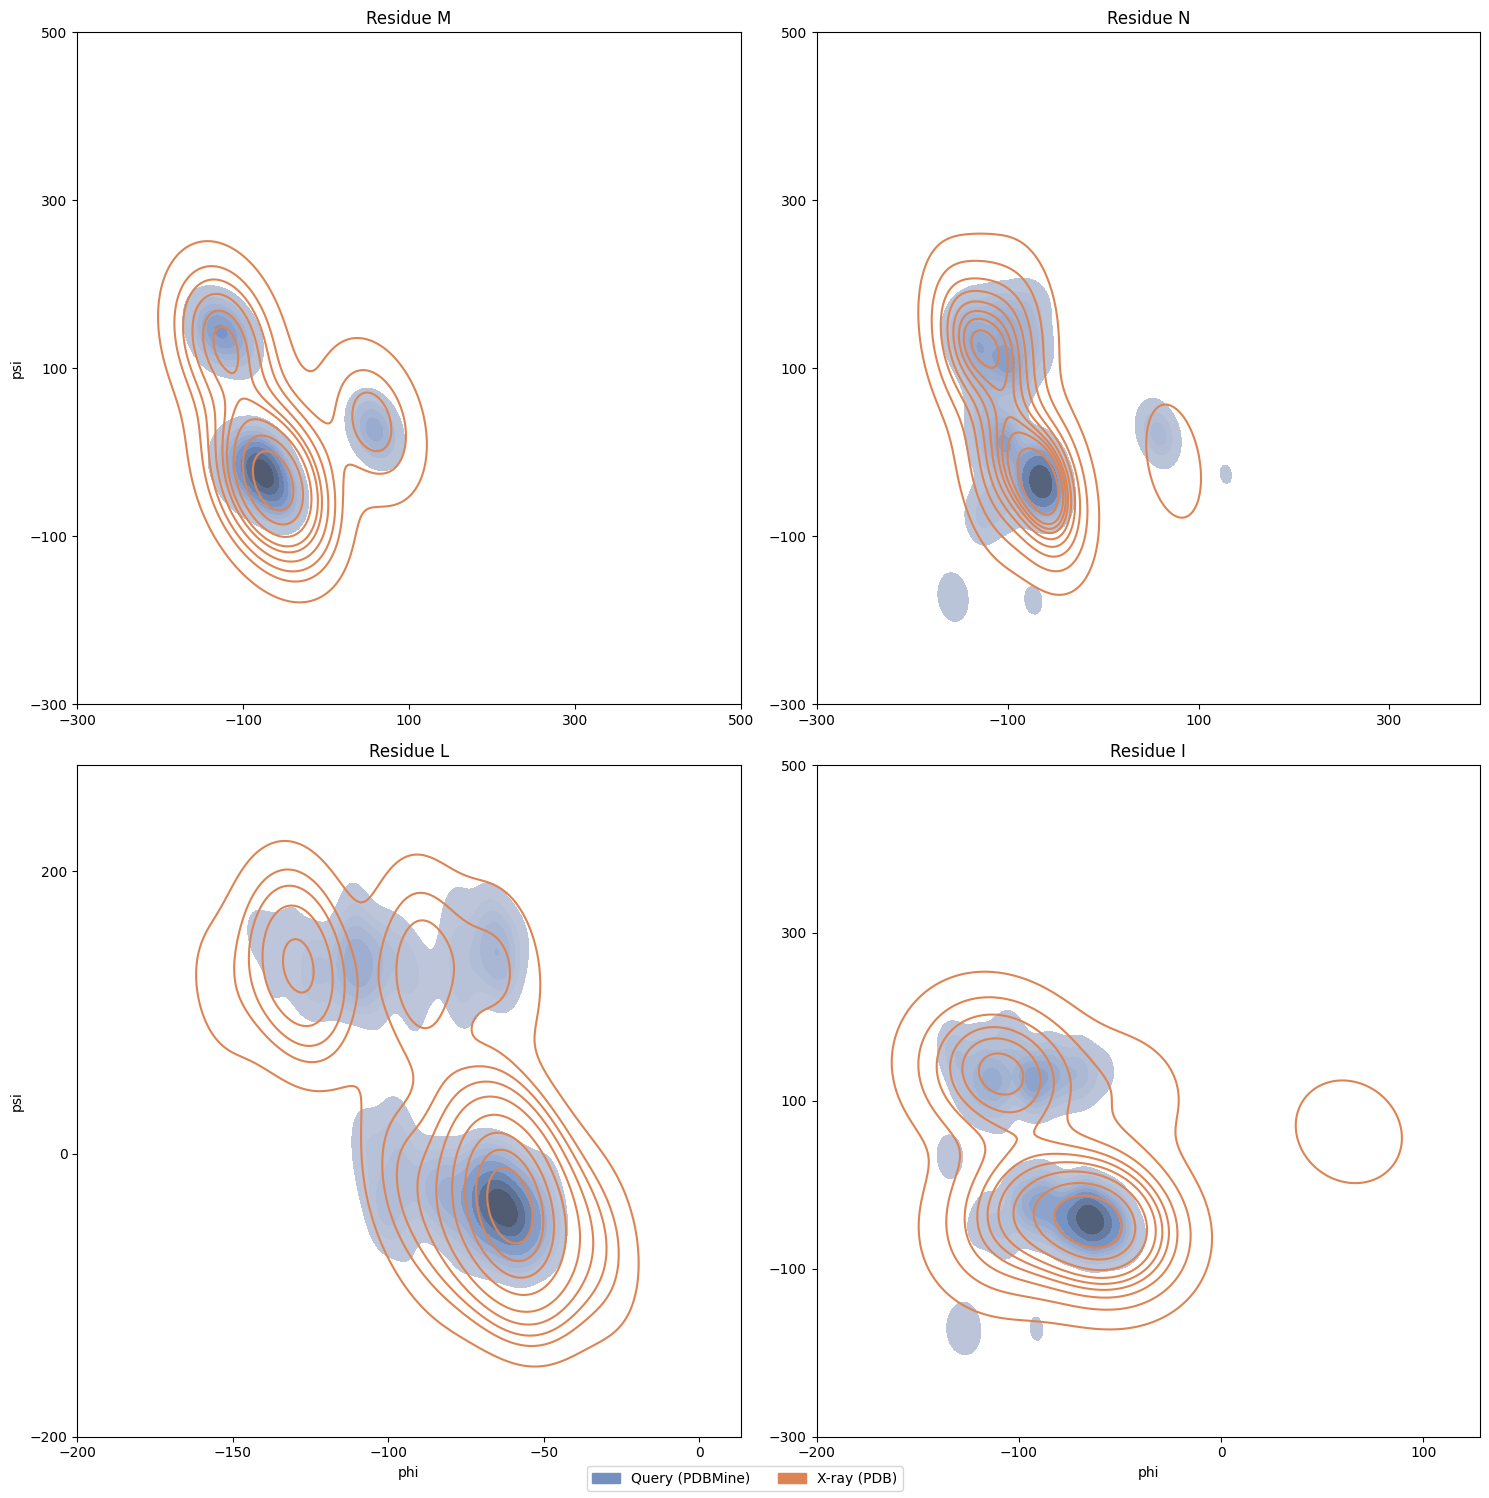

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot PDB

fig, axes = plt.subplots(2,2,figsize=(15,15))

m=0
for i,key in enumerate(phi_psi_pdb.res.unique()[m:m+4]):
    ax = axes.flatten()[i]
    phi_psi_alpha = phi_psi_pdb[phi_psi_pdb.res == key]
    phi_psi_dist = phi_psi_mined_filtered[phi_psi_mined_filtered.res == key]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    sns.kdeplot(data=phi_psi_alpha, x='phi', y='psi', ax=ax, fill=False, zorder=10, color='#dd8452', legend=True)

    ax.set_title(f'Residue {key}')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yticks(ax.get_yticks()[::2])
    ax.set_xlabel('phi' if i > 1 else '')
    ax.set_ylabel('psi' if i % 2 == 0 else '')


# legend on bottom middle
patch1 = mpatches.Patch(color='#7490c0', label='Query (PDBMine)')
patch2 = mpatches.Patch(color='#dd8452', label='X-ray (PDB)')
fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2)
# fig.suptitle(f'Distribution of phi, psi angles for the residues in {protein_id_pdb}')
plt.tight_layout()

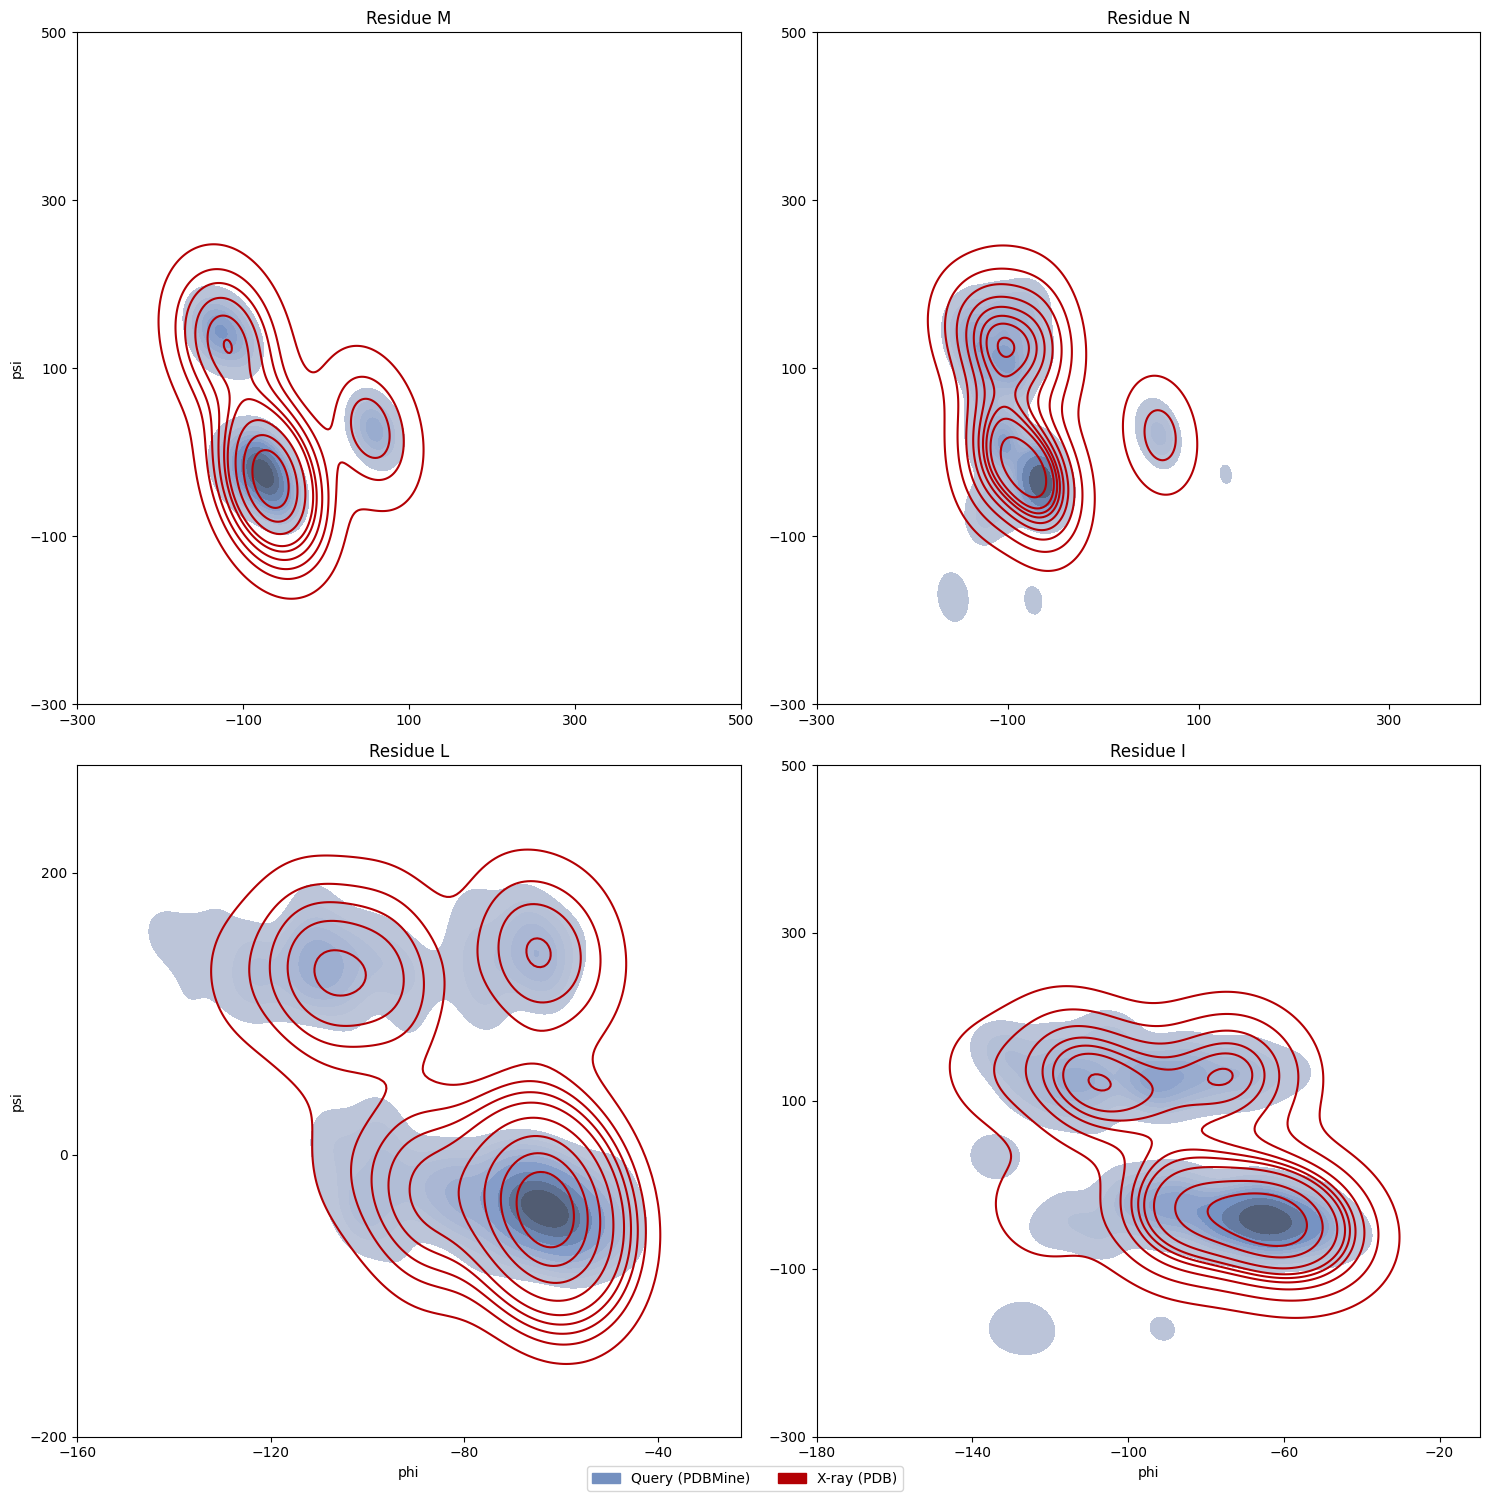

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot PDB

fig, axes = plt.subplots(2,2,figsize=(15,15))

m=0
for i,key in enumerate(phi_psi_af.res.unique()[m:m+4]):
    ax = axes.flatten()[i]
    phi_psi_alpha = phi_psi_af[phi_psi_af.res == key]
    phi_psi_dist = phi_psi_mined_filtered[phi_psi_mined_filtered.res == key]
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
    sns.kdeplot(data=phi_psi_alpha, x='phi', y='psi', ax=ax, fill=False, zorder=10, color='#b30004', legend=True)

    ax.set_title(f'Residue {key}')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yticks(ax.get_yticks()[::2])
    ax.set_xlabel('phi' if i > 1 else '')
    ax.set_ylabel('psi' if i % 2 == 0 else '')


# legend on bottom middle
patch1 = mpatches.Patch(color='#7490c0', label='Query (PDBMine)')
patch2 = mpatches.Patch(color='#b30004', label='X-ray (PDB)')
fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2)
# fig.suptitle(f'Distribution of phi, psi angles for the residues in {protein_id_pdb}')
plt.tight_layout()